In [1]:
import pandas as pd


In [2]:
peaks_bed=pd.read_csv("/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/K562_02.17.2022_bias_128_4_1234_0.5_fold_0/09_06_2022_motif_scanning_profile_new/merged.k562.bed",sep="\t", header=None)
import pyBigWig as pw

bw = pw.open("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/K562/ATAC/pval.bigWig")
dbw = pw.open("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/K562/DNASE/K562.merged.filtered.sorted.pval.signal.bigwig")



In [3]:
peaks_bed.shape

(192695, 3)

In [4]:
#peaks_bed.head()
#bw.values("chr1",40585,41341)

In [5]:
dnase_name=pd.read_csv("configs/data/counts.tomtom_dnase.tsv",sep="\t")
atac_name=pd.read_csv("configs/data/profile.tomtom.tsv",sep="\t")

In [6]:
dnase_dict={}
for i,r in dnase_name.iterrows():
    if "metacluster_0" not in r["Pattern"]:
        continue
    key = r["Pattern"].replace("metacluster_","").replace("pattern_","").replace(".","_")+"_"+r["Match_1"]
    dnase_dict[key] = r["Label"]
    
atac_dict={}
for i,r in atac_name.iterrows():
    if "metacluster_0" not in r["Pattern"]:
        continue

    key = r["Pattern"].replace("metacluster_","").replace("pattern_","").replace(".","_")+"_"+r["Match_1"]
    atac_dict[key] = r["Label"]

In [7]:
dnase_bed="/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/DNASE_PE/K562/K562_05.13.2022_bias_128_4_1234_0.5_fold_0/09_06_2022_motif_scanning/mooods_dir_eith_atac_profile_new/overlaps_resolved_based_on_cwm_activations_normed.bed"
atac_bed="/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/K562_02.17.2022_bias_128_4_1234_0.5_fold_0/09_06_2022_motif_scanning_profile_new/overlaps_resolved_based_on_cwm_activations_normed.bed"

In [8]:
dnase_hits = pd.read_csv(dnase_bed,sep="\t",header=None)
atac_hits = pd.read_csv(atac_bed,sep="\t",header=None)

In [9]:
atac_hits[3].replace(atac_dict,inplace=True)
dnase_hits[3].replace(atac_dict,inplace=True)

In [10]:
atac_hits = atac_hits.loc[~atac_hits[3].isin(["1_13_SP2_HUMAN.H11MO.0.A", "DIMER", "NA", "GC"])]
dnase_hits = dnase_hits.loc[~dnase_hits[3].isin(["1_13_SP2_HUMAN.H11MO.0.A", "DIMER", "NA", "GC"])]


In [11]:
new_dict={"BACH.1":"AP1","ZN143":"ZNF76","FOSL1+JUN\n":"AP1","BACH":"AP1","JUND":"AP1","CEBPG":"AP1","ETV4":"ELK"}
atac_hits[3].replace(new_dict,inplace=True)
atac_hits.dropna(inplace=True)
dnase_hits[3].replace(new_dict,inplace=True)
dnase_hits.dropna(inplace=True)

In [12]:
len(set(atac_hits[6]))

163126

In [13]:
len(set(dnase_hits[6]))

175160

In [14]:
all_keys = list(set(atac_hits[3]))
atac_hits['combined'] = atac_hits[[0,1,2,3]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
dnase_hits['combined'] = dnase_hits[[0,1,2,3]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)


In [15]:
def jaccard(list1, list2):
    list1 = set(list1)
    list2 = set(list2)
    
    intersection = len(list(list1.intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    #print(intersection,union)
    #if (float(intersection) / union) < 0.2:
    #    print(list1.symmetric_difference(list2))
    return float(intersection) / union


In [16]:
import numpy as np
peak_ids = set(atac_hits[6])
jaccard_scores=[]
pval_signal = []
for peak_idx in peak_ids:
    peak_hits_atac = atac_hits[atac_hits[6]==peak_idx]['combined']
    peak_hits_dnase = dnase_hits[dnase_hits[6]==peak_idx]['combined']
    score = jaccard(peak_hits_atac.tolist(), peak_hits_dnase.tolist())
    r = peaks_bed.loc[peak_idx,:]
    pval_signal.append(np.max([np.max(bw.values(r[0],r[1],r[2])),np.max(dbw.values(r[0],r[1],r[2]))]))
    jaccard_scores.append(score)

In [17]:
import matplotlib.pyplot as plt

{'whiskers': [<matplotlib.lines.Line2D at 0x7fab70711650>,
 'caps': [<matplotlib.lines.Line2D at 0x7fab70777090>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fab707112d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fab707252d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fab70725610>],
 'means': []}

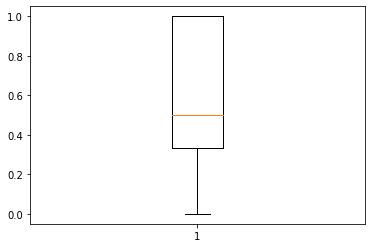

In [18]:
plt.boxplot(jaccard_scores)

In [97]:

def equal_bin_v2(N, m):
    idx = np.linspace(0,m,N.size, endpoint=0).astype(int)
    return idx[N.argsort().argsort()]  

#bins = np.linspace(0, 12, 10)
#digitized = np.digitize(np.log(pval_signal), bins)
#bin_means = [np.mean(np.array(jaccard_scores)[digitized == i]) for i in range(1, len(bins))]

idxs = equal_bin_v2(np.log(pval_signal), 10)
bin_means = [np.mean(np.array(jaccard_scores)[idxs == i]) for i in range(0, max(idxs))]
pval_means = [np.mean(np.log(pval_signal)[idxs == i]) for i in range(0, max(idxs))]
bin_std = [np.std(np.array(jaccard_scores)[idxs == i]) for i in range(0, max(idxs))]


<ErrorbarContainer object of 3 artists>

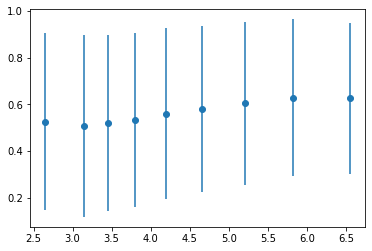

In [101]:
plt.errorbar(pval_means, bin_means, yerr=bin_std, fmt='o')


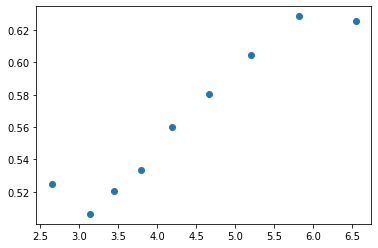

In [102]:
plt.scatter(pval_means,bin_means)


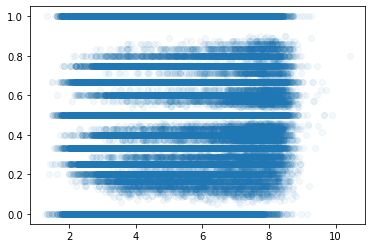

In [73]:
plt.scatter(np.log(pval_signal),jaccard_scores,alpha=0.05)

In [22]:
np.array(list(peak_ids))[(np.array(jaccard_scores)==1) & (np.log(pval_signal)>8)]

array([   722,    973,   1311,   1655,   3216,   3289,   4121,   4186,
         4309,   4821,   4829,   5247,   5396,   5570,   6199,   6226,
         6406,   6756,   7342,  10411,  11115,  11255,  12035,  12414,
        12568,  13892,  15654,  16691,  17202,  17305,  17400,  17828,
        18316,  18972,  19430,  19718,  19723,  20337,  20424,  21236,
        21577,  21743,  21777,  22454,  24624,  26898,  26960,  27236,
        27557,  31225,  31353,  31591,  31805,  33386,  34686,  34885,
        35195,  35442,  35845,  38073,  38620,  39628,  42432,  42916,
        43187,  43225,  44417,  45062,  45668,  46804,  48260,  49033,
        50530,  53124,  56108,  58368,  59167,  59282,  59766,  60557,
        60626,  60627,  62886,  62963,  63827,  64204,  64249,  64385,
        66091,  66354,  66540,  68134,  69169,  69233,  69905,  70098,
        70194,  72405,  72456,  73127,  73647,  74532,  74663,  75024,
        75045,  75047,  75958,  77104,  77281,  78243,  78252,  78826,
      

In [23]:

np.array(list(peak_ids))[(np.array(jaccard_scores)==1) & (np.log(pval_signal)>8)]


array([   722,    973,   1311,   1655,   3216,   3289,   4121,   4186,
         4309,   4821,   4829,   5247,   5396,   5570,   6199,   6226,
         6406,   6756,   7342,  10411,  11115,  11255,  12035,  12414,
        12568,  13892,  15654,  16691,  17202,  17305,  17400,  17828,
        18316,  18972,  19430,  19718,  19723,  20337,  20424,  21236,
        21577,  21743,  21777,  22454,  24624,  26898,  26960,  27236,
        27557,  31225,  31353,  31591,  31805,  33386,  34686,  34885,
        35195,  35442,  35845,  38073,  38620,  39628,  42432,  42916,
        43187,  43225,  44417,  45062,  45668,  46804,  48260,  49033,
        50530,  53124,  56108,  58368,  59167,  59282,  59766,  60557,
        60626,  60627,  62886,  62963,  63827,  64204,  64249,  64385,
        66091,  66354,  66540,  68134,  69169,  69233,  69905,  70098,
        70194,  72405,  72456,  73127,  73647,  74532,  74663,  75024,
        75045,  75047,  75958,  77104,  77281,  78243,  78252,  78826,
      

In [24]:
peaks_bed.loc[116983]

0       chr3
1    9862277
2    9863057
Name: 116983, dtype: object

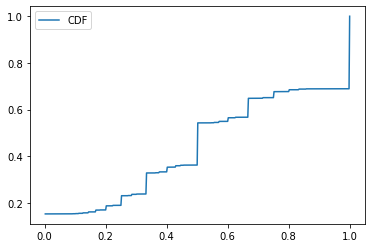

In [25]:
import numpy as np
# getting data of the histogram
count, bins_count = np.histogram(jaccard_scores, bins=500)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()

In [26]:
np.median(jaccard_scores)

0.5

In [27]:
np.mean(jaccard_scores)

0.5638982418491638